In [11]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize

# Exercise 1

## Question 1.1.

In [108]:
def European_call_MC_Average(r, S0, sigma, T, K, N):
    
    WT1 = np.sqrt(T)*npr.normal(0,1,(N,1))
    WT2 = np.sqrt(T)*npr.normal(0,1,(N,1))
    ST1 = S0*np.exp( sigma*WT1 + (r-0.5*sigma**2)*T)
    ST2 = S0*np.exp( sigma*WT2 + (r-0.5*sigma**2)*T)

    payoff = np.exp(-r*T)*np.maximum((ST1+ST2)/2 - K, 0)
    
    price  = np.mean(payoff)
    std    = np.std(payoff)
    CI_up   = price +1.96*std/np.sqrt(N)     
    CI_down = price -1.96*std/np.sqrt(N)
    error   = std/np.sqrt(N)
    
    return {'price':price, 'error':error, 'CI_up':CI_up, 'CI_down':CI_down}

European_call_MC_Average(
    r=0.01,
    S0=100,
    sigma=0.2,
    T=1, # one year
    K=100,
    N=1000000
)

{'price': 6.169184909037861,
 'error': 0.009372314595451717,
 'CI_up': 6.187554645644947,
 'CI_down': 6.150815172430776}

## Question 1.3.

In [82]:
def European_call_MC_Average_IS_grid(r, S0, sigma, T, K, N,
                                IS1_min, IS1_max, IS2_min, IS2_max, resolution):
    # ISX_max/min are the bounds for the graph
    # resolution is the resolution of the graph
    
    lamb1_vals = [IS1_min + k*(IS1_max-IS1_min)/resolution for k in range(resolution+1)]
    lamb2_vals = [IS2_min + k*(IS2_max-IS2_min)/resolution for k in range(resolution+1)]
    
    error_matrix = np.zeros((resolution+1, resolution+1))
    
    for i in range(resolution + 1):
        lamb1 = lamb1_vals[i]
        for j in range(resolution + 1):
            lamb2 = lamb2_vals[j]
            
            G1 = npr.normal(0,1,(N,1))
            WT1 = np.sqrt(T)*(G1 + lamb1)
            G2 = npr.normal(0,1,(N,1))
            WT2 = np.sqrt(T)*(G2 + lamb2)
            
            ST1 = S0*np.exp( sigma*WT1 + (r-0.5*sigma**2)*T)
            ST2 = S0*np.exp( sigma*WT2 + (r-0.5*sigma**2)*T)

            payoff = np.exp(
                -r*T
            )*np.exp(
                -lamb1*G1 - lamb1**2/2 - lamb2*G2 - lamb2**2/2
            )*np.maximum((ST1+ST2)/2 - K, 0)
            
            error_matrix[i, j] = np.std(payoff)/np.sqrt(N)
    
    return pd.DataFrame(
        columns=lamb2_vals,
        index=lamb1_vals,
        data=error_matrix
    )

plot_data = European_call_MC_Average_IS_grid(
    r=0.01,
    S0=100,
    sigma=0.2,
    T=1, # one year
    K=100,
    N=1000000,
    IS1_min=0, 
    IS1_max=1.5,
    IS2_min=0,
    IS2_max=1.5,
    resolution=15
)

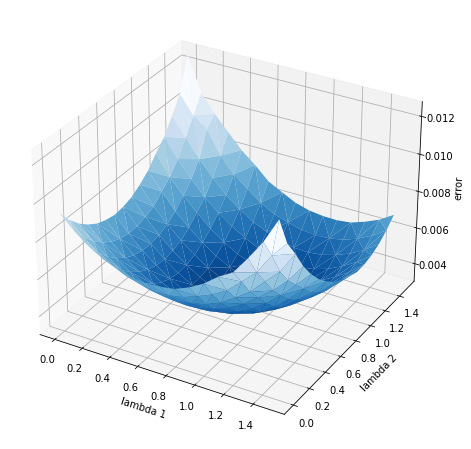

In [81]:
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
plot_data_coords = plot_data.stack().reset_index()
ax = plt.axes(projection='3d')
ax.plot_trisurf(
    plot_data_coords['level_0'].values,
    plot_data_coords['level_1'].values,
    plot_data_coords[0].values,
    cmap=cm.Blues_r
)
ax.set_xlabel('lambda 1')
ax.set_ylabel('lambda 2')
ax.set_zlabel('error')
plt.savefig('question 1.3.png', bbox_inches='tight', dpi=200)
plt.show()

In [104]:
from scipy.optimize import minimize

def European_call_MC_Average_IS(r, S0, sigma, T, K, N, lamb1, lamb2):
    
    G1 = npr.normal(0,1,(N,1))
    WT1 = np.sqrt(T)*(G1 + lamb1)
    G2 = npr.normal(0,1,(N,1))
    WT2 = np.sqrt(T)*(G2 + lamb2)

    ST1 = S0*np.exp( sigma*WT1 + (r-0.5*sigma**2)*T)
    ST2 = S0*np.exp( sigma*WT2 + (r-0.5*sigma**2)*T)

    payoff = np.exp(
        -r*T
    )*np.exp(
        -lamb1*G1 - lamb1**2/2 - lamb2*G2 - lamb2**2/2
    )*np.maximum((ST1+ST2)/2 - K, 0)

    return np.std(payoff)/np.sqrt(N)

def objective_function(x):
    return European_call_MC_Average_IS(
        r=0.01,
        S0=100,
        sigma=0.2,
        T=1, # one year
        K=100,
        N=1000000,
        lamb1=x,
        lamb2=x
    )

minimize(
    objective_function,
    method = 'Nelder-Mead',
    x0=1
)

 final_simplex: (array([[0.8375    ],
       [0.83759766]]), array([0.00319482, 0.0031978 ]))
           fun: 0.0031948194833692485
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 13
        status: 0
       success: True
             x: array([0.8375])

## Question 1.4.

In [109]:
def European_put_MC_Average_IS(r, S0, sigma, T, K, N, lamb):
    
    G1 = npr.normal(0,1,(N,1))
    WT1 = np.sqrt(T)*(G1 + lamb)
    G2 = npr.normal(0,1,(N,1))
    WT2 = np.sqrt(T)*(G2 + lamb)

    ST1 = S0*np.exp( sigma*WT1 + (r-0.5*sigma**2)*T)
    ST2 = S0*np.exp( sigma*WT2 + (r-0.5*sigma**2)*T)

    payoff = np.exp(
        -r*T
    )*np.exp(
        -lamb*G1 - lamb**2/2 - lamb*G2 - lamb**2/2
    )*np.maximum(K - (ST1+ST2)/2, 0)

    return np.std(payoff)/np.sqrt(N)

def objective_function(x):
    return European_put_MC_Average_IS(
        r=0.01,
        S0=100,
        sigma=0.2,
        T=1, # one year
        K=100,
        N=1000000,
        lamb=x
    )

minimize(
    objective_function,
    method = 'Nelder-Mead',
    x0=1
)

 final_simplex: (array([[-0.7875    ],
       [-0.78740234]]), array([0.00278775, 0.00278921]))
           fun: 0.0027877479411300573
       message: 'Optimization terminated successfully.'
          nfev: 41
           nit: 18
        status: 0
       success: True
             x: array([-0.7875])

# Exercise 2

## Question 2.2.

In [5]:
def Asian_call_MC_BS(r,S0,sigma,T,K,N,n):
    
    G = npr.normal(0,1,(N,n))
    step = T/n
    
    Log_returns = sigma*np.sqrt(step)*G + (r-sigma**2/2)*step
    Log_returns_S0 = np.concatenate((np.ones((N,1))*np.log(S0),Log_returns),axis=1)
    Log_Paths = np.cumsum(Log_returns_S0, axis=1)
    Spaths = np.exp(Log_Paths)
    S_bar = np.mean(Spaths[:,:-1],axis=1) 
    payoff = np.exp(-r*T)*np.maximum(S_bar-K,0)
    
    price = np.mean(payoff)
    std = np.std(payoff)
    CI_up = price +1.96*std/np.sqrt(N)     
    CI_down = price -1.96*std/np.sqrt(N)
    error = 1.96*std/np.sqrt(N)
    
    return {'price':price, 'error':error, 'CI_up':CI_up, 'CI_down':CI_down}

Asian_call_MC_BS(0.01, 100, 0.2, 1, 100, 1000000, 10)

{'price': 4.449701414511032,
 'error': 0.01348146322656857,
 'CI_up': 4.463182877737601,
 'CI_down': 4.436219951284463}

In [39]:
def Asian_call_MC_BS_CV(r,S0,sigma,T,K,N,n,c):
    # c is the weight given to the control variate in the payoff estimator
    
    G = npr.normal(0,1,(N,n))
    step = T/n
    
    # payoff:
    Log_returns = sigma*np.sqrt(step)*G + (r-sigma**2/2)*step
    Log_returns_S0 = np.concatenate((np.ones((N,1))*np.log(S0),Log_returns),axis=1)
    Log_Paths = np.cumsum(Log_returns_S0, axis=1)
    Spaths = np.exp(Log_Paths)
    S_bar = np.mean(Spaths[:,:-1],axis=1)
    
    # control variate:
    Log_returns = sigma*np.sqrt(step)*G + (r-sigma**2/2)*step
    Log_returns_S0 = np.concatenate((np.ones((N,1))*np.log(S0),Log_returns),axis=1)
    Log_Paths = np.cumsum(Log_returns_S0, axis=1)
    Spaths = np.exp(Log_Paths)
    CV = np.exp(-r*T + np.mean(Log_Paths[:,:-1],axis=1))
    cv_expect = np.exp(-r*T + np.log(S0) + T*(r/2-sigma**2/4) + (sigma**4*T**2)/18)
    
    # estimator for the payoff:
    payoff = np.exp(-r*T)*np.maximum(S_bar-K,0) + c*(CV - cv_expect)
    
    std = np.std(payoff)
    error = std/np.sqrt(N)
    
    return error

def objective_function2(x):
    return Asian_call_MC_BS_CV(0.01, 100, 0.2, 1, 100, 1000000, 10, x)

In [48]:
print("error of the naive estimator: ", objective_function2(0))

error of the naive estimator:  0.006895225534565381


In [55]:
c_vals = [0.05*k for k in range(-30, 11)]
plot_vals = [objective_function2(c) for c in c_vals]

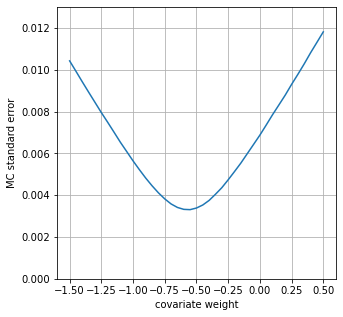

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylim(0, 0.013)
ax.set_xlabel('covariate weight')
ax.set_ylabel('MC standard error')
plt.grid()
plt.plot(c_vals, plot_vals)
plt.savefig('question 2.2.png', bbox_inches='tight', dpi=200)
plt.show()

In [45]:
minimize(
    objective_function2,
    method = 'Nelder-Mead',
    x0=1
)

 final_simplex: (array([[-0.55664063],
       [-0.55654297]]), array([0.00329652, 0.00330969]))
           fun: 0.0032965235427302865
       message: 'Optimization terminated successfully.'
          nfev: 43
           nit: 19
        status: 0
       success: True
             x: array([-0.55664063])

In [47]:
def Asian_call_MC_BS_CV2(r,S0,sigma,T,K,N,n,c):
    # c is the weight given to the control variate in the payoff estimator
    
    G = npr.normal(0,1,(N,n))
    step = T/n
    
    # payoff:
    Log_returns = sigma*np.sqrt(step)*G + (r-sigma**2/2)*step
    Log_returns_S0 = np.concatenate((np.ones((N,1))*np.log(S0),Log_returns),axis=1)
    Log_Paths = np.cumsum(Log_returns_S0, axis=1)
    Spaths = np.exp(Log_Paths)
    S_bar = np.mean(Spaths[:,:-1],axis=1)
    
    # control variate:
    Log_returns = sigma*np.sqrt(step)*G + (r-sigma**2/2)*step
    Log_returns_S0 = np.concatenate((np.ones((N,1))*np.log(S0),Log_returns),axis=1)
    Log_Paths = np.cumsum(Log_returns_S0, axis=1)
    Spaths = np.exp(Log_Paths)
    CV = np.exp(-r*T)*np.maximum(np.exp(np.mean(Log_Paths[:,:-1],axis=1)) - K, 0)
    
    alpha = -r*T + np.log(S0) + T*(r/2-sigma**2/4)
    beta = sigma**2*T/3
    cv_expect = np.exp(
        -r*T
    )*(
        np.exp(
            alpha + beta**2/2
        )*norm.cdf(
            (alpha - beta**2 - K)/beta
        ) - K*norm.cdf(
            (alpha - K)/beta
        )
    )
    
    # estimator for the payoff:
    payoff = np.exp(-r*T)*np.maximum(S_bar-K,0) + c*(CV - cv_expect)
    
    std = np.std(payoff)
    error = std/np.sqrt(N)
    
    return error

def objective_function3(x):
    return Asian_call_MC_BS_CV2(0.01, 100, 0.2, 1, 100, 1000000, 10, x)

In [49]:
print("error of the naive estimator: ", objective_function3(0))

error of the naive estimator:  0.006880193226240569


In [56]:
c_vals = [0.05*k for k in range(-30, 11)]
plot_vals2 = [objective_function3(c) for c in c_vals]

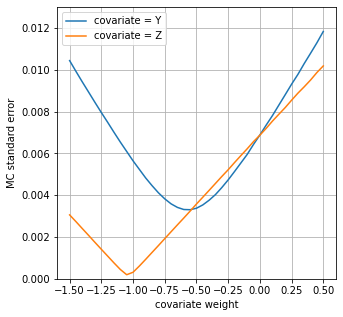

In [58]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylim(0, 0.013)
ax.set_xlabel('covariate weight')
ax.set_ylabel('MC standard error')
plt.grid()
plt.plot(c_vals, plot_vals, label='covariate = Y')
plt.plot(c_vals, plot_vals2, label='covariate = Z')
plt.legend()
plt.savefig('question 2.4.png', bbox_inches='tight', dpi=200)
plt.show()

In [53]:
minimize(
    objective_function3,
    method = 'Nelder-Mead',
    x0=-1
)

 final_simplex: (array([[-1.03867187],
       [-1.03876953]]), array([0.00017974, 0.00018077]))
           fun: 0.00017974435950059582
       message: 'Optimization terminated successfully.'
          nfev: 24
           nit: 11
        status: 0
       success: True
             x: array([-1.03867187])